# Choral Synthesizer

For disquiet 0419 we were given lots of samples at lots of frequencies with lots of overtones and
lots of qualities. I would like to be able to synthesize a sort of haunting tone at a roughly constant
frequency in a stero signal given those. So pull all the samples apart with librosa and build something
which is kind of a long grain granular synth / mixer / retuner.

In [15]:
import math
import numpy as np
import librosa
import os
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

sr = 48000

In [41]:
def loadAllFiles():
    res = {}
    for fn in os.listdir( "samples/" ):
        (res[ fn ],_unusedsr) = librosa.load("samples/" + fn, sr=sr, mono=True)
    return res

allFileData = loadAllFiles()

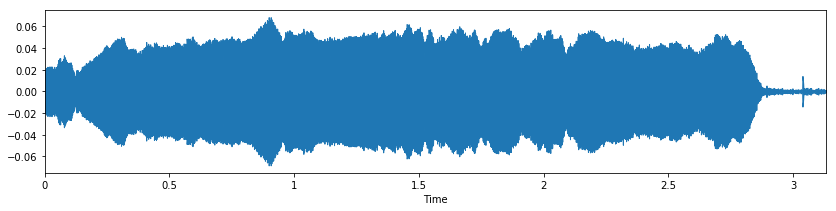

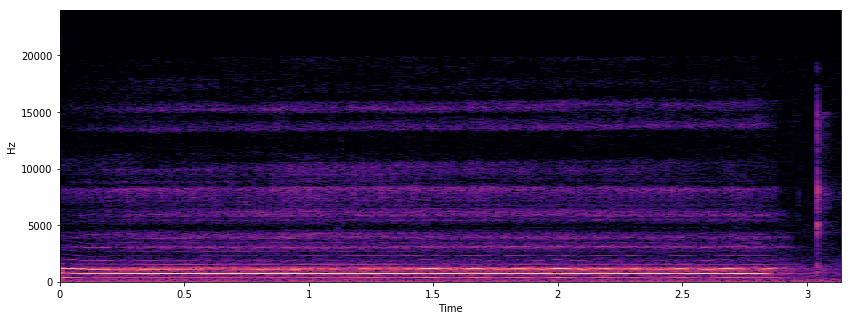

In [42]:
def showFile( fn ):
    fd = allFileData[fn]
    plt.figure( figsize=(14,3))
    librosa.display.waveplot(fd,sr=sr)
    X = librosa.stft(fd)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

showFile( 'ejkelly-g4-aah.wav')

In [43]:
fd = allFileData['ejkelly-g4-aah.wav']
pitches, magnitudes = librosa.core.piptrack(fd, sr=sr, fmin=75, fmax=2000, n_fft=2048)
[np.shape(pitches), np.shape(fd), np.shape(fd)[0] / np.shape(pitches)[1]]

[(1025, 294), (150416,), 511.6190476190476]

In [44]:
fd = allFileData['baconpaul-daughter-g-ahh.wav']
pitches, magnitudes = librosa.core.piptrack(fd, sr=sr, fmin=75, fmax=2000)
[np.shape(pitches), np.shape(fd), np.shape(fd)[0] / np.shape(pitches)[1]]

[(1025, 385), (196608,), 510.67012987012987]

OK great, so clearly the piptrack gives us the frequency spectrum in 512 block length intervals. That's really useful. At our sample rate how many blocks give us a tenth of a second? The answer is "about 10 blocks"

In [49]:
time = 512/sr
blocks = 0.1 / time
[time, blocks]

[0.010666666666666666, 9.375]

What's in that pitches array and magnitude array? Take a single slice

In [73]:
fd = allFileData['baconpaul-daughter-g-ahh.wav']
pitches, magnitudes = librosa.core.piptrack(fd, sr=sr, fmin=40, fmax=5000)

p120 = pitches[:,120]
m120 = magnitudes[:,120]

i0 = -1
for i in range(len(m120)):
    if( m120[i] > 5):
        if( i0 < 0 ):
            i0 = i
        print( p120[i], " " , m120[i], " ", p120[i] / p120[i0])

395.56644   26.871807   1.0
790.71655   28.013731   1.9989475
1183.9298   19.080135   2.9929986
1577.828   10.021453   3.9887812


And hey would you look at that, theres the fundamental and first four harmonics from that sample. Great.

And so now we can introduce

## A plan of attack

The dataset I want is all 10-block streaks where the fundamental is roughly the same, along with the fundamental. If I have that, I can use that streak to join together a tone at that fundamental. I can also do some alias-y time stretching and shrinking to adjust pitch. 

In [74]:
pitchAndMagnitudeData = {}
for k in allFileData.keys():
    pitchAndMagnitudeData[k] = librosa.core.piptrack(allFileData[k], sr=sr, fmin=40, fmax=5000)

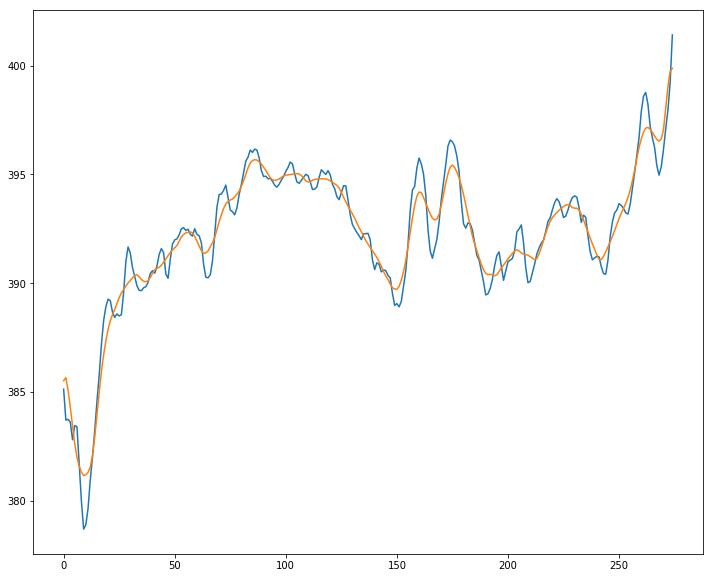

In [110]:
def fundaments(fn):
    (p,m) = pitchAndMagnitudeData[fn]
    shape = np.shape(p)
    nObs = shape[1]
    fundamental = np.zeros( nObs )
    for i in range( nObs ):
        thisp = p[:,i]
        thism = m[:,i]
        found = False
        for j in range( len( thisp ) ):
            if( thism[j] > 5 and not found ):
                fundamental[i] = thisp[j]
                found = True
            if( found ):
                break
    smoothed =  np.convolve( fundamental, np.ones((10,))/10, mode='same' )
    edges = np.abs(smoothed - fundamental)
    valid = np.logical_and( edges < 5, fundamental > 40 )
    return (fundamental, smoothed, valid )
    
(f,smoothed,valid) = fundaments( 'baconpaul-daughter-g-ahh.wav' )
plt.figure(figsize=(12, 10))
plt.plot( f[valid] )
plt.plot( smoothed[valid] )


So now we have a mechanism to find the approximate frequency of a 10 block chunk. Cool. So lets calculate that curve for everyone.

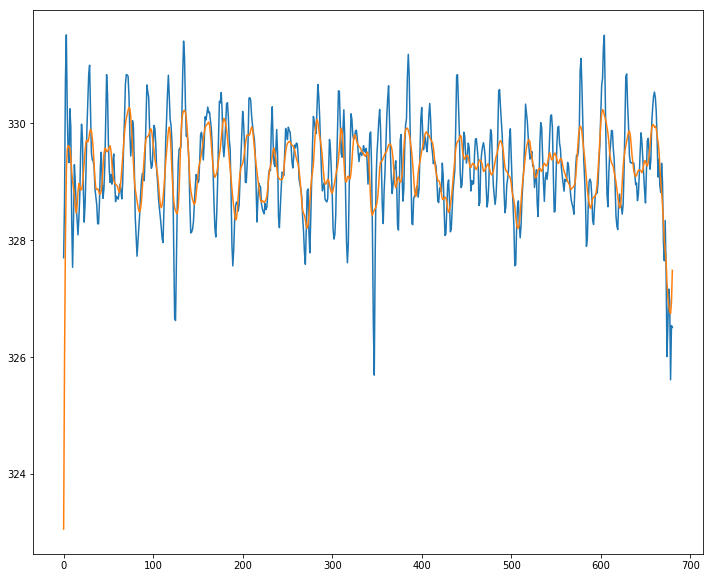

In [111]:
(f,smoothed,valid) = fundaments( 'samarobryn--e.wav' )
plt.figure(figsize=(12, 10))
plt.plot( f[valid] )
plt.plot( smoothed[valid] )


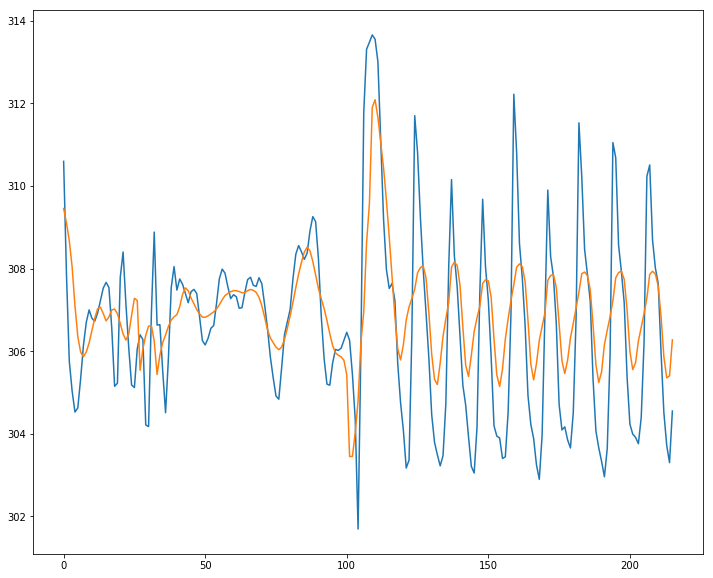

In [112]:
(f,smoothed,valid) = fundaments( 'Patricia Wolf Dischorus Ohhh.wav' )
plt.figure(figsize=(12, 10))
plt.plot( f[valid] )
plt.plot( smoothed[valid] )

In [114]:
fundamentsData = {}
for k in allFileData.keys():
    fundamentsData[k] = fundaments(k)